---
title: "Simulating today's hockey games"
description: "Run monte carlo simulations using the expected goals model to predict the winners of today's games"
author: "chicken"
date: "1/27/2026"
categories:
    - "tutorials"
image: charts/2026-01-24_NSH.png
lightbox: true
draft: false
---

## **Intro**

Use the `chickenstats` library to scrape play-by-play data, aggregate to the team level, then run monte 
carlo simulations to predict the winners of today's games.

Parts of this tutorial are optional and will be clearly marked as such. For help, or any questions,
please don't hesitate to reach out to [chicken@chickenandstats.com](mailto:chicken@chickenandstats.com) or
[@chickenandstats.com](https://bsky.app/profile/chickenandstats.com) on Blue Sky.

---

![](./charts/2026-01-24_NSH.png)

---

## **Housekeeping**

### Import dependencies

Import the dependencies we'll need for the guide

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl

from pathlib import Path
import datetime as dt


from chickenstats.chicken_nhl import Scraper, Season
from chickenstats.chicken_nhl._helpers import charts_directory
from chickenstats.chicken_nhl.team import NHL_COLORS

from monte_carlo import (
    aggregate_strength_states,
    prep_nhl_stats,
    prep_team_stats,
    prep_todays_games,
    simulate_game,
    predict_game,
    predict_games,
    process_winners,
    assess_predictions,
)

### Polars options

Set different polars options. This cell is optional

In [ ]:
pl.Config.set_tbl_cols(-1)

polars.config.Config

### Folder structure

In [ ]:
charts_directory()

### Chickenstats matplotlib style

chickenstats.utilities includes a custom style package - this activates it. This cell is also optional

In [ ]:
plt.style.use("chickenstats")

---

## **Scrape data**

### Schedule

Scrape the schedule using the `Season` object

In [ ]:
season = Season(2025, backend="polars")

In [ ]:
schedule = season.schedule()

Output()

### Standings and team names

Scrape the standings and create team name dictionaries to use later

In [ ]:
standings = season.standings

In [ ]:
standings.head(5)

season,date,team,team_name,conference,division,games_played,points,points_pct,wins,regulation_wins,shootout_wins,losses,ot_losses,shootout_losses,ties,win_pct,regulation_win_pct,streak_code,streak_count,goals_for,goals_against,goals_for_pct,goal_differential,goal_differential_pct,home_games_played,home_points,home_goals_for,home_goals_against,home_goal_differential,home_wins,home_losses,home_ot_losses,home_ties,home_regulation_wins,road_games_played,road_points,road_goals_for,road_goals_against,road_goal_differential,road_wins,road_losses,road_ot_losses,road_ties,road_regulation_wins,l10_points,l10_goals_for,l10_goals_against,l10_goal_differential,l10_wins,l10_losses,l10_ot_losses,l10_ties,l10_regulation_wins,team_logo,wildcard_sequence,waivers_sequence
i64,str,str,str,str,str,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,str,i64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
20252026,"""2026-02-05""","""COL""","""Colorado Avalanche""","""Western""","""Central""",55,83,0.754545,37,34,1,9,9,null,0,0.672727,0.618182,"""W""",1,212,138,3.854545,74,1.345455,28,46,117,66,51,21,3,4,0,21,27,37,95,72,23,16,6,5,0,13,9,30,35,-5,4,5,1,0,4,"""https://assets.nhle.com/logos/…",0,32
20252026,"""2026-02-05""","""CAR""","""Carolina Hurricanes""","""Eastern""","""Metropolitan""",57,78,0.684211,36,26,4,15,6,null,0,0.631579,0.45614,"""W""",3,197,163,3.45614,34,0.596491,31,44,118,94,24,21,8,2,0,15,26,34,79,69,10,15,7,4,0,11,18,39,21,18,8,0,2,0,7,"""https://assets.nhle.com/logos/…",0,30
20252026,"""2026-02-05""","""MIN""","""Minnesota Wild""","""Western""","""Central""",58,78,0.672414,34,21,4,14,10,null,0,0.586207,0.362069,"""W""",5,196,169,3.37931,27,0.465517,30,41,97,91,6,17,6,7,0,9,28,37,99,78,21,17,8,3,0,12,17,46,33,13,8,1,1,0,3,"""https://assets.nhle.com/logos/…",0,28
20252026,"""2026-02-05""","""DAL""","""Dallas Stars""","""Western""","""Central""",57,77,0.675439,34,28,4,14,9,null,0,0.596491,0.491228,"""W""",6,193,160,3.385965,33,0.578947,26,35,85,72,13,16,7,3,0,13,31,42,108,88,20,18,7,6,0,15,14,32,27,5,7,3,0,0,5,"""https://assets.nhle.com/logos/…",0,29
20252026,"""2026-02-05""","""TBL""","""Tampa Bay Lightning""","""Eastern""","""Atlantic""",54,76,0.703704,36,27,4,14,4,null,0,0.666667,0.5,"""W""",4,193,139,3.574074,54,1.0,26,34,85,70,15,17,9,0,0,11,28,42,108,69,39,19,5,4,0,16,17,35,24,11,8,1,1,0,4,"""https://assets.nhle.com/logos/…",0,31


In [ ]:
team_names = standings.sort(by="team_name")["team_name"].str.to_uppercase().to_list()
team_codes = standings.sort(by="team_name")["team"].str.to_uppercase().to_list()
team_names_dict = dict(zip(team_codes, team_names, strict=False))

home_teams = dict(zip(schedule["game_id"].to_list(), schedule["home_team"].to_list(), strict=False))

### Game IDs

Create a list of game IDs to scrape

In [ ]:
conds = pl.col("game_state") == "OFF"

game_ids = schedule.filter(conds)["game_id"].unique().to_list()

### Latest date
Important! If you don't set this, it will just pull from the last completed game

In [ ]:
conds = pl.col("game_state") == "OFF"

dt_format = "%Y-%m-%d"
latest_date_dt = schedule.filter(conds)["game_date"].str.to_datetime(format=dt_format).max()  # In YYYY-MM-DD format
latest_date = latest_date_dt.strftime(dt_format)

latest_date = "2026-01-24"
latest_date_dt = dt.date(year=int(latest_date[:4]), month=int(latest_date[5:7]), day=int(latest_date[8:10]))

### Checking to see if you've already scraped the data
Check to see if you've already scraped, so you're only getting the game_ids that you need

In [ ]:
data_directory = Path.cwd() / "data"
stats_file = data_directory / "team_stats.csv"

if not data_directory.exists():
    data_directory.mkdir()

if stats_file.exists():
    team_stats = pl.read_csv(source=stats_file, infer_schema_length=2000)

    saved_game_ids = team_stats["game_id"].to_list()
    game_ids = [x for x in game_ids if x not in saved_game_ids]

In [ ]:
if game_ids:
    scraper = Scraper(game_ids, backend="polars")

    pbp = scraper.play_by_play
    scraped_team_stats = scraper.team_stats

Output()

Output()

### Combine scraped and saved data
Combine the scraped data and the saved data, then save the new file, but only if there are game_ids

In [ ]:
if game_ids:
    team_stats = pl.concat(
        [team_stats.with_columns(pl.col("bsf_adj_percent").cast(pl.Float64)), scraped_team_stats], strict=False
    )  # Quick, don't ask
    team_stats.write_csv(stats_file)

In [ ]:
team_stats.head(5)

season,session,game_id,game_date,team,opp_team,strength_state,toi,gf,ga,gf_adj,ga_adj,hdgf,hdga,xgf,xga,xgf_adj,xga_adj,sf,sa,sf_adj,sa_adj,hdsf,hdsa,ff,fa,ff_adj,fa_adj,hdff,hdfa,cf,ca,cf_adj,ca_adj,bsf,bsa,bsf_adj,bsa_adj,msf,msa,msf_adj,msa_adj,hdmsf,hdmsa,teammate_block,hf,ht,give,take,ozf,nzf,dzf,fow,fol,ozfw,ozfl,nzfw,nzfl,dzfw,dzfl,pent0,pent2,pent4,pent5,pent10,pend0,pend2,pend4,pend5,pend10,gf_p60,ga_p60,gf_adj_p60,ga_adj_p60,hdgf_p60,hdga_p60,xgf_p60,xga_p60,xgf_adj_p60,xga_adj_p60,sf_p60,sa_p60,sf_adj_p60,sa_adj_p60,hdsf_p60,hdsa_p60,ff_p60,fa_p60,ff_adj_p60,fa_adj_p60,hdff_p60,hdfa_p60,cf_p60,ca_p60,cf_adj_p60,ca_adj_p60,bsf_p60,bsa_p60,bsf_adj_p60,bsa_adj_p60,msf_p60,msa_p60,msf_adj_p60,msa_adj_p60,hdmsf_p60,hdmsa_p60,teammate_block_p60,hf_p60,ht_p60,give_p60,take_p60,pent0_p60,pent2_p60,pent4_p60,pent5_p60,pent10_p60,pend0_p60,pend2_p60,pend4_p60,pend5_p60,pend10_p60,gf_percent,gf_adj_percent,hdgf_percent,xgf_percent,xgf_adj_percent,sf_percent,sf_adj_percent,hdsf_percent,ff_percent,ff_adj_percent,hdff_percent,cf_percent,cf_adj_percent,bsf_percent,bsf_adj_percent,msf_percent,msf_adj_percent,hdmsf_percent,hf_percent,take_percent
i64,str,i64,str,str,str,str,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,"""R""",2025020813,"""2026-01-24""","""CAR""","""OTT""","""5v4""",5.5,0,0,0.0,0.0,0,0,0.266756,0.175814,0.311799,0.153621,1,1,1.200956,1.200956,1,0,1,2,1.205802,2.411605,1,0,1,2,1.205802,2.411605,0,0,0.0,0.0,0,1,0.0,0.854207,0,0,0,1,0,1,0,0,2,3,0,5,0,0,0,2,0,3,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.910065,1.917967,3.40144,1.67587,10.909091,10.909091,13.101342,13.101342,10.909091,0.0,10.909091,21.818182,13.154208,26.308416,10.909091,0.0,10.909091,21.818182,13.154208,26.308416,0.0,0.0,0.0,0.0,0.0,10.909091,0.0,9.31862,0.0,0.0,0.0,10.909091,0.0,10.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.909091,0.0,0.0,0.0,NaN,NaN,NaN,0.602743,0.66993,0.5,0.5,1.0,0.333333,0.333333,1.0,0.333333,0.333333,NaN,NaN,0.0,0.0,NaN,1.0,0.0
20252026,"""R""",2025020103,"""2025-10-21""","""FLA""","""BOS""","""4v5""",9.3,0,1,0.0,0.868644,0,1,0.337972,0.40907,0.388038,0.357434,2,3,1.78708,2.569967,0,1,3,6,2.6342,5.125241,0,2,3,9,2.6342,5.125241,0,3,0.0,0.0,1,3,1.205802,2.56262,0,1,0,3,1,1,0,5,1,3,3,6,0,5,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0.0,6.451613,0.0,5.604155,0.0,6.451613,2.180462,2.639159,2.503471,2.306027,12.903226,19.354839,11.529549,16.580431,0.0,6.451613,19.354839,38.709677,16.994839,33.066069,0.0,12.903226,19.354839,58.064516,16.994839,33.066069,0.0,19.354839,0.0,0.0,6.451613,19.354839,7.77937,16.533035,0.0,6.451613,0.0,19.354839,6.451613,6.451613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452414,0.520526,0.4,0.410159,0.0,0.333333,0.339483,0.0,0.25,0.339483,0.0,NaN,0.25,0.319975,0.0,0.75,0.0
20252026,"""R""",2025020849,"""2026-01-29""","""NYR""","""NYI""","""5v4""",5.366667,1,0,0.868644,0.0,0,0,0.217852,0.0,0.190353,0.0,2,0,1.713311,0.0,0,0,2,0,1.708414,0.0,0,0,4,0,1.708414,0.0,2,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,3,2,0,2,1,4,3,4,2,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,11.180124,0.0,9.711549,0.0,0.0,0.0,2.435613,0.0,2.128175,0.0,22.360248,0.0,19.155032,0.0,0.0,0.0,22.360248,0.0,19.100276,0.0,0.0,0.0,44.720497,0.0,19.100276,0.0,22.360248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.540373,22.360248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0
20252026,"""R""",2025020247,"""2025-11-09""","""OTT""","""UTA""","""5vE""",2.766667,0,0,0.0,0.0,0,0,0.594731,0.609058,0.594731,0.60905

---

## **Munge the data**

Cleaning the data and prepping for analysis

### Add Home games to the data set
Check to see if team is the home team, adding a dummy column

In [ ]:
home_map = dict(zip(schedule["game_id"], schedule["home_team"], strict=False))

team_stats = team_stats.with_columns(
    is_home=pl.when(pl.col("game_id").replace_strict(home_map, return_dtype=str) == pl.col("team"))
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
)

### Aggregate strength state

Add a column to aggregate strength states (e.g., powerplay for 5v4, 5v3, and 4v3)

In [ ]:
team_stats = aggregate_strength_states(team_stats)

### Prep overall NHL stats

Function to calculate the goals scored and allowed above the expected goals model, 
at the overall NHL season level, adjusted for score and venue

In [ ]:
nhl_stats = prep_nhl_stats(team_stats)

In [ ]:
nhl_stats.head(5)

season,session,is_home,strength_state2,toi,gf,ga,gf_adj,ga_adj,hdgf,hdga,xgf,xga,xgf_adj,xga_adj,sf,sa,sf_adj,sa_adj,hdsf,hdsa,ff,fa,ff_adj,fa_adj,hdff,hdfa,cf,ca,cf_adj,ca_adj,bsf,bsa,bsf_adj,bsa_adj,msf,msa,msf_adj,msa_adj,hdmsf,hdmsa,teammate_block,hf,ht,give,take,ozf,nzf,dzf,fow,fol,ozfw,ozfl,nzfw,nzfl,dzfw,dzfl,pent0,pent2,pent4,pent5,pent10,pend0,pend2,pend4,pend5,pend10,game_id,g_score_ax,g_save_ax,toi_gp,gf_p60,ga_p60,gf_adj_p60,ga_adj_p60,xgf_p60,xga_p60,xgf_adj_p60,xga_adj_p60,g_score_ax_p60,g_save_ax_p60
i64,str,i32,str,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,"""R""",0,"""Ev5""",536.35,57,166,57.0,166.0,20,37,69.020614,179.961909,69.020614,179.961909,494,166,494.0,166.0,159,37,794,307,794.0,306.0,228,37,1150,418,794.0,306.0,318,111,0.0,0.0,300,141,300.0,140.0,69,0,38,67,94,109,24,262,29,211,274,228,262,0,12,17,0,211,0,23,0,3,6,0,332,4,2,2,483,-12.020614,13.961909,1.110455,6.376433,18.569964,6.376433,18.569964,7.721146,20.131844,7.721146,20.131844,-1.344713,1.56188
20252026,"""R""",0,"""3vE""",2.5,0,0,0.0,0.0,0,0,0.0,1.110907,0.0,1.110907,0,6,0.0,6.0,0,2,0,8,0.0,8.0,0,2,0,9,0.0,8.0,0,1,0.0,0.0,0,2,0.0,2.0,0,0,0,0,0,0,0,1,0,2,2,1,0,1,0,0,2,0,0,6,0,0,0,0,0,0,0,0,9,0.0,1.110907,0.277778,0.0,0.0,0.0,0.0,0.0,26.661775,0.0,26.661775,0.0,26.661775
20252026,"""R""",0,"""Ev4""",40.0,9,10,9.0,10.0,3,2,8.10169,7.612753,8.10169,7.612753,45,10,45.0,10.0,7,2,78,15,78.0,15.0,12,2,111,22,78.0,15.0,28,7,0.0,0.0,33,5,33.0,5.0,5,0,5,1,4,5,2,34,1,13,34,14,34,0,0,1,0,13,0,2,0,0,0,0,8,0,0,0,53,0.89831,-2.387247,0.754717,13.5,15.0,13.5,15.0,12.152535,11.419129,12.152535,11.419129,1.347465,-3.580871
20252026,"""R""",0,"""powerplay""",4105.033333,514,49,555.923431,51.608182,222,26,632.442075,50.900359,685.593593,47.745515,3541,625,3757.638052,659.030873,1103,119,5362,793,5728.852631,842.420465,1592,150,6988,891,5728.852631,842.420465,1463,98,0.0,0.0,1821,168,1945.086182,158.628621,489,31,163,179,517,823,174,1943,624,1732,2334,1965,1888,55,347,277,99,1633,4,154,0,2,1,0,87,4,2,1,883,-129.670162,-3.862667,4.648962,7.512728,0.716194,8.12549,0.754316,9.243902,0.74397,10.020775,0.697858,-1.895285,-0.056458
20252026,"""R""",1,"""ILLEGAL""",1.9,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,0,0,2,0.0,0.0,0,0,0,2,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,13,0,0,0,19,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Prep team stats

Function to prep and aggregate team stats to match up with the schedule for predicting the game's values

In [ ]:
team_stats_agg = prep_team_stats(team_stats=team_stats, nhl_stats=nhl_stats, latest_date=latest_date)

In [ ]:
team_stats_agg.head(5)

season,session,team,is_home,strength_state2,toi,gf,ga,gf_adj,ga_adj,hdgf,hdga,xgf,xga,xgf_adj,xga_adj,sf,sa,sf_adj,sa_adj,hdsf,hdsa,ff,fa,ff_adj,fa_adj,hdff,hdfa,cf,ca,cf_adj,ca_adj,bsf,bsa,bsf_adj,bsa_adj,msf,msa,msf_adj,msa_adj,hdmsf,hdmsa,teammate_block,hf,ht,give,take,ozf,nzf,dzf,fow,fol,ozfw,ozfl,nzfw,nzfl,dzfw,dzfl,pent0,pent2,pent4,pent5,pent10,pend0,pend2,pend4,pend5,pend10,game_id,g_score_ax,g_save_ax,toi_gp,gf_p60,ga_p60,gf_adj_p60,ga_adj_p60,xgf_p60,xga_p60,xgf_adj_p60,xga_adj_p60,g_score_ax_p60,g_save_ax_p60,mean_xgf_p60,mean_xga_p60,mean_xgf_adj_p60,mean_xga_adj_p60,mean_gf_p60,mean_ga_p60,mean_gf_adj_p60,mean_ga_adj_p60,mean_g_score_ax_p60,mean_g_save_ax_p60,mean_toi_gp,off_strength,def_strength,toi_comparison,scoring_strength,goalie_strength
i64,str,str,i32,str,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,"""R""","""CBJ""",1,"""4vE""",0.866667,1,0,1.0,0.0,0,0,0.61581,0.049193,0.61581,0.049193,1,1,1.0,1.0,0,0,1,1,1.0,1.0,0,0,1,1,1.0,1.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.38419,0.049193,0.866667,69.230769,0.0,69.230769,0.0,42.63297,3.405685,42.63297,3.405685,26.5978,3.405685,11.419129,12.152535,11.419129,12.152535,15.0,13.5,15.0,13.5,3.580871,-1.347465,0.754717,3.733469,0.280245,1.148333,7.427746,-2.527476
20252026,"""R""","""NSH""",1,"""4vE""",1.766667,0,1,0.0,1.0,0,0,0.0,0.13276,0.0,0.13276,0,2,0.0,2.0,0,0,0,4,0.0,4.0,0,0,0,4,0.0,4.0,0,0,0.0,0.0,0,2,0.0,2.0,0,0,0,0,0,0,0,2,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0,-0.86724,0.883333,0.0,33.962264,0.0,33.962264,0.0,4.508823,0.0,4.508823,0.0,-29.453441,11.419129,12.152535,11.419129,12.152535,15.0,13.5,15.0,13.5,3.580871,-1.347465,0.754717,0.0,0.371019,1.170417,0.0,21.858415
20252026,"""R""","""DAL""",0,"""ILLEGAL""",0.383333,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3,0.0,0.0,0.127778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,NaN,NaN,1.277778,NaN,NaN
20252026,"""R""","""PHI""",0,"""ILLEGAL""",0.083333,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0,0,1,0,0.0,0.0,0,0,1,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,NaN,NaN,0.833333,NaN,NaN
20252026,"""R""","""NJD""",0,"""shorthanded""",120.933333,2,16,1.737288,15.06796,0,6,1.977491,20.020203,2.213706,18.863242,17,116,16.053371,110.466815,6,33,24,171,22.643352,162.09692,6,52,27,213,22.643352,162.09692,3,42,0.0,0.0,7,55,7.463236,52.44747,0,19,0,13,7,19,11,73,18,58,64,85,2,71,6,12,56,2,0,5,0,0,0,0,6,0,0,0,26,-0.476418,3.795282,4.651282,0.992282,7.938258,0.86194,7.475834,0.981115,9.932846,1.098311,9.35883,-0.236371,1.882996,0.755118,9.38011,0.826901,8.675806,0.892854,7.649225,0.836282,7.069986,0.009381,1.60582,5.064586,1.328225,1.078727,0.918393,-25.197613,1.172607


### Prep today's games
Function to prepare today's games

In [ ]:
todays_games = prep_todays_games(schedule=schedule, team_stats=team_stats, nhl_stats=nhl_stats, latest_date=latest_date)

In [ ]:
todays_games.head(5)

season,session,game_id,game_date,start_time,game_state,home_team,home_team_id,home_score,away_team,away_team_id,away_score,venue,venue_timezone,neutral_site,game_date_dt_utc,tv_broadcasts,home_logo,home_logo_dark,away_logo,away_logo_dark,home_5v5_off_strength,home_5v5_def_strength,home_5v5_scoring_strength,home_5v5_goalie_strength,home_5v5_toi_comparison,home_powerplay_off_strength,home_powerplay_scoring_strength,home_powerplay_toi_comparison,home_shorthanded_def_strength,home_shorthanded_goalie_strength,home_shorthanded_toi_comparison,away_5v5_off_strength,away_5v5_def_strength,away_5v5_scoring_strength,away_5v5_goalie_strength,away_5v5_toi_comparison,away_powerplay_off_strength,away_powerplay_scoring_strength,away_powerplay_toi_comparison,away_shorthanded_def_strength,away_shorthanded_goalie_strength,away_shorthanded_toi_comparison,mean_home_5v5_xgf_p60,mean_home_5v5_xga_p60,mean_home_5v5_xgf_adj_p60,mean_home_5v5_xga_adj_p60,mean_home_5v5_gf_p60,mean_home_5v5_ga_p60,mean_home_5v5_gf_adj_p60,mean_home_5v5_ga_adj_p60,mean_home_5v5_g_score_ax_p60,mean_home_5v5_g_save_ax_p60,mean_home_5v5_toi_gp,mean_home_powerplay_xgf_p60,mean_home_powerplay_xga_p60,mean_home_powerplay_xgf_adj_p60,mean_home_powerplay_xga_adj_p60,mean_home_powerplay_gf_p60,mean_home_powerplay_ga_p60,mean_home_powerplay_gf_adj_p60,mean_home_powerplay_ga_adj_p60,mean_home_powerplay_g_score_ax_p60,mean_home_powerplay_g_save_ax_p60,mean_home_powerplay_toi_gp,mean_home_shorthanded_xgf_p60,mean_home_shorthanded_xga_p60,mean_home_shorthanded_xgf_adj_p60,mean_home_shorthanded_xga_adj_p60,mean_home_shorthanded_gf_p60,mean_home_shorthanded_ga_p60,mean_home_shorthanded_gf_adj_p60,mean_home_shorthanded_ga_adj_p60,mean_home_shorthanded_g_score_ax_p60,mean_home_shorthanded_g_save_ax_p60,mean_home_shorthanded_toi_gp,mean_away_5v5_xgf_p60,mean_away_5v5_xga_p60,mean_away_5v5_xgf_adj_p60,mean_away_5v5_xga_adj_p60,mean_away_5v5_gf_p60,mean_away_5v5_ga_p60,mean_away_5v5_gf_adj_p60,mean_away_5v5_ga_adj_p60,mean_away_5v5_g_score_ax_p60,mean_away_5v5_g_save_ax_p60,mean_away_5v5_toi_gp,mean_away_powerplay_xgf_p60,mean_away_powerplay_xga_p60,mean_away_powerplay_xgf_adj_p60,mean_away_powerplay_xga_adj_p60,mean_away_powerplay_gf_p60,mean_away_powerplay_ga_p60,mean_away_powerplay_gf_adj_p60,mean_away_powerplay_ga_adj_p60,mean_away_powerplay_g_score_ax_p60,mean_away_powerplay_g_save_ax_p60,mean_away_powerplay_toi_gp,mean_away_shorthanded_xgf_p60,mean_away_shorthanded_xga_p60,mean_away_shorthanded_xgf_adj_p60,mean_away_shorthanded_xga_adj_p60,mean_away_shorthanded_gf_p60,mean_away_shorthanded_ga_p60,mean_away_shorthanded_gf_adj_p60,mean_away_shorthanded_ga_adj_p60,mean_away_shorthanded_g_score_ax_p60,mean_away_shorthanded_g_save_ax_p60,mean_away_shorthanded_toi_gp,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_home_5v5_xgf_p60,predicted_home_5v5_xga_p60,predicted_home_5v5_gf_p60,predicted_home_5v5_ga_p60,predicted_home_powerplay_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_shorthanded_xga_p60,predicted_home_shorthanded_ga_p60,predicted_away_5v5_xgf_p60,predicted_away_5v5_xga_p60,predicted_away_5v5_gf_p60,predicted_away_5v5_ga_p60,predicted_away_powerplay_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_shorthanded_xga_p60,predicted_away_shorthanded_ga_p60
i64,i64,i64,str,str,str,str,i64,i64,str,i64,i64,str,str,i64,"datetime[μs, UTC]",list[struct[5]],str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,2,2025020810,"""2026-01-24""","""13:00""","""OFF""","""NYI""",2,0,"""BUF""",7,5,"""UBS ARENA""","""America/New_York""",0,2026-01-24 18:00:

---

## Simulating the actual games
Functions to simulate the games

### Random float
Generate a random floating number between 0 and 1

### Simulating an individual game
Predicts various game values, based on a poissoin distribution

In [ ]:
game = todays_games.filter((pl.col("away_team") == "NSH") | (pl.col("home_team") == "NSH")).to_dicts()[0]

In [ ]:
pl.DataFrame(simulate_game(game))  # Showing it as a dataframe just to make it easy

game_id,home_team,away_team,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_away_5v5_toi,predicted_away_powerplay_toi,predicted_away_shorthanded_toi,predicted_home_5v5_gf_p60,predicted_home_5v5_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_powerplay_xgf_p60,predicted_home_5v5_goals,predicted_home_powerplay_goals,predicted_home_total_goals,predicted_away_5v5_gf_p60,predicted_away_5v5_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_powerplay_xgf_p60,predicted_away_5v5_goals,predicted_away_powerplay_goals,predicted_away_total_goals,home_win,away_win,draw
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
2025020811,"""NSH""","""UTA""",43.0,2.0,8.0,43.0,8.0,2.0,3.0,3.0,1.0,13.0,2.15,0.433333,2.583333,NaN,1.0,18.0,5.0,0.716667,0.666667,1.383333,1,0,0


### Predict an entire game
Predict an entire game based on n number of simulations

In [ ]:
predicted_game = predict_game(game, 100)

Output()

In [ ]:
predicted_game.head(5)

game_id,home_team,away_team,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_away_5v5_toi,predicted_away_powerplay_toi,predicted_away_shorthanded_toi,predicted_home_5v5_gf_p60,predicted_home_5v5_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_powerplay_xgf_p60,predicted_home_5v5_goals,predicted_home_powerplay_goals,predicted_home_total_goals,predicted_away_5v5_gf_p60,predicted_away_5v5_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_powerplay_xgf_p60,predicted_away_5v5_goals,predicted_away_powerplay_goals,predicted_away_total_goals,home_win,away_win,draw
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
2025020811,"""NSH""","""UTA""",49.6,4.0,6.4,49.6,6.4,4.0,0.0,3.0,2.0,8.0,2.48,0.533333,3.013333,NaN,1.0,14.0,4.0,0.826667,0.426667,1.253333,1,0,0
2025020811,"""NSH""","""UTA""",36.0,3.0,4.0,36.0,4.0,3.0,2.0,1.0,1.0,4.0,0.6,0.2,0.8,NaN,2.0,13.0,6.0,1.2,0.4,1.6,0,1,0
2025020811,"""NSH""","""UTA""",44.262295,7.868852,7.868852,44.262295,7.868852,7.868852,1.0,1.0,2.0,9.0,0.737705,1.180328,1.918033,NaN,5.0,12.0,1.0,3.688525,0.131148,3.819672,0,1,0
2025020811,"""NSH""","""UTA""",49.52381,5.714286,4.761905,49.52381,4.761905,5.714286,1.0,3.0,1.0,6.0,2.47619,0.571429,3.047619,NaN,5.0,10.0,8.0,4.126984,0.634921,4.761905,0,1,0
2025020811,"""NSH""","""UTA""",44.0,6.0,9.0,44.0,9.0,6.0,0.0,1.0,4.0,9.0,0.733333,0.9,1.633333,NaN,6.0,11.0,4.0,4.4,0.6,5.0,0,1,0


### Simulating multiple games
Simulating multiple games at once

In [ ]:
predictions = predict_games(predict_game, todays_games, total_simulations=1_000, n_workers=1, disable_progress_bar=True)

In [ ]:
predictions.head(5)

game_id,home_team,away_team,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_away_5v5_toi,predicted_away_powerplay_toi,predicted_away_shorthanded_toi,predicted_home_5v5_gf_p60,predicted_home_5v5_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_powerplay_xgf_p60,predicted_home_5v5_goals,predicted_home_powerplay_goals,predicted_home_total_goals,predicted_away_5v5_gf_p60,predicted_away_5v5_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_powerplay_xgf_p60,predicted_away_5v5_goals,predicted_away_powerplay_goals,predicted_away_total_goals,home_win,away_win,draw
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
2025020810,"""NYI""","""BUF""",52.5,2.5,5.0,52.5,5.0,2.5,0.0,2.0,16.0,12.0,1.75,0.5,2.25,7.0,4.0,55.0,12.0,3.5,1.0,4.5,0,1,0
2025020810,"""NYI""","""BUF""",52.131148,1.967213,5.901639,52.131148,5.901639,1.967213,0.0,3.0,22.0,10.0,2.606557,0.327869,2.934426,9.0,4.0,59.0,6.0,3.47541,0.590164,4.065574,0,1,0
2025020810,"""NYI""","""BUF""",52.5,4.6875,2.8125,52.5,2.8125,4.6875,0.0,5.0,19.0,9.0,4.375,0.703125,5.078125,9.0,5.0,59.0,15.0,4.375,0.703125,5.078125,0,0,1
2025020810,"""NYI""","""BUF""",33.0,10.0,2.0,33.0,2.0,10.0,0.0,1.0,22.0,13.0,0.55,2.166667,2.716667,9.0,3.0,66.0,20.0,1.65,0.666667,2.316667,1,0,0
2025020810,"""NYI""","""BUF""",40.0,1.0,0.0,40.0,0.0,1.0,1.0,4.0,11.0,5.0,2.666667,0.083333,2.75,8.0,5.0,59.0,16.0,3.333333,0.0,3.333333,0,1,0


---

## Assessing results
Check to see if the simulation is accurate

### Process winners
Aggregate the predictions to "predict" a winner

In [ ]:
predicted_winners = process_winners(predictions)

In [ ]:
predicted_winners

game_id,home_team,away_team,predicted_winner,predicted_home_win,predicted_away_win,predicted_draw,predicted_home_win_percent,predicted_away_win_percent,predicted_draw_percent,predicted_home_5v5_goals_mean,predicted_home_powerplay_goals_mean,predicted_home_total_goals_mean,predicted_home_5v5_xgf_p60_mean,predicted_home_powerplay_xgf_p60_mean,predicted_home_5v5_toi_mean,predicted_home_powerplay_toi_mean,predicted_home_shorthanded_toi_mean,predicted_away_5v5_goals_mean,predicted_away_powerplay_goals_mean,predicted_away_total_goals_mean,predicted_away_5v5_xgf_p60_mean,predicted_away_powerplay_xgf_p60_mean,predicted_away_5v5_toi_mean,predicted_away_powerplay_toi_mean,predicted_away_shorthanded_toi_mean
i64,str,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025020817,"""MIN""","""FLA""","""FLA""",461,536,3,0.461,0.536,0.003,2.075311,0.739172,2.814484,2.773,6.988,44.898838,6.308386,4.402776,2.113866,0.868102,2.981968,2.826,11.836,44.898838,4.402776,6.308386
2025020814,"""CBJ""","""TBL""","""TBL""",306,690,4,0.306,0.69,0.004,1.906553,0.669293,2.575845,2.45,9.007,46.679519,4.449252,4.628229,2.824785,0.760766,3.585551,3.629,9.881,46.679519,4.628229,4.449252
2025020813,"""OTT""","""CAR""","""CAR""",459,537,4,0.459,0.537,0.004,1.976862,0.557561,2.534423,2.65,5.609,44.872112,5.927584,5.440304,2.062832,0.643848,2.70668,2.756,7.065,44.872112,5.440304,5.927584
2025020812,"""BOS""","""MTL""","""MTL""",397,600,3,0.397,0.6,0.003,1.894879,0.762433,2.657312,2.557,8.452,44.568994,5.414241,6.037765,1.968763,1.177527,3.14629,2.643,11.672,44.568994,6.037765,5.414241
2025020811,"""NSH""","""UTA""","""UTA""",433,564,3,0.433,0.564,0.003,2.00005,0.517972,2.518022,2.606,6.436,46.140582,4.837774,5.105645,2.318929,0.587029,2.905959,3.018,6.945,46.140582,5.105645,4.837774
2025020810,"""NYI""","""BUF""","""BUF""",372,623,5,0.372,0.623,0.005,2.113746,0.624885,2.738631,2.711,8.495,46.857121,4.435936,4.562943,2.491938,0.903787,3.395725,3.19,11.983,46.857121,4.562943,4.435936
2025020818,"""EDM""","""WSH""","""EDM""",500,499,1,0.5,0.499,0.001,2.303046,1.020846,3.323892,2.984,12.598,46.357211,4.832619,4.49217,2.356921,0.908569,3.265491,3.058,12.179,46.357211,4.49217,4.832619
2025020816,"""STL""","""LAK""","""LAK""",378,613,9,0.378,0.613,0.009,1.787255,0.412386,2.199641,2.244,5.351,47.567413,4.592821,4.259765,1.969469,0.647448,2.616917,2.494,9.101,47.567413,4.259765,4.592821
2025020815,"""WPG""","""DET""","""DET""",361,633,6,0.361,0.633,0.006,2.177507,0.577372,2.754879,2.81,8.746,46.495734,3.938766,5.2035,2.535959,0.955715,3.491675,3.274,11.014,46.495734,5.2035,3.938766


### Assessing predictions
Checking to see if the predictions were correct

In [ ]:
assessed_predictions = assess_predictions(predicted_winners, schedule)

In [ ]:
assessed_predictions

game_id,home_team,away_team,predicted_winner,actual_winner,prediction_correct,predicted_home_win,predicted_away_win,predicted_draw,predicted_home_win_percent,predicted_away_win_percent,predicted_draw_percent,predicted_home_5v5_goals_mean,predicted_home_powerplay_goals_mean,predicted_home_total_goals_mean,predicted_home_5v5_xgf_p60_mean,predicted_home_powerplay_xgf_p60_mean,predicted_home_5v5_toi_mean,predicted_home_powerplay_toi_mean,predicted_home_shorthanded_toi_mean,predicted_away_5v5_goals_mean,predicted_away_powerplay_goals_mean,predicted_away_total_goals_mean,predicted_away_5v5_xgf_p60_mean,predicted_away_powerplay_xgf_p60_mean,predicted_away_5v5_toi_mean,predicted_away_powerplay_toi_mean,predicted_away_shorthanded_toi_mean
i64,str,str,str,str,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025020817,"""MIN""","""FLA""","""FLA""","""FLA""",1,461,536,3,0.461,0.536,0.003,2.075311,0.739172,2.814484,2.773,6.988,44.898838,6.308386,4.402776,2.113866,0.868102,2.981968,2.826,11.836,44.898838,4.402776,6.308386
2025020814,"""CBJ""","""TBL""","""TBL""","""CBJ""",0,306,690,4,0.306,0.69,0.004,1.906553,0.669293,2.575845,2.45,9.007,46.679519,4.449252,4.628229,2.824785,0.760766,3.585551,3.629,9.881,46.679519,4.628229,4.449252
2025020813,"""OTT""","""CAR""","""CAR""","""CAR""",1,459,537,4,0.459,0.537,0.004,1.976862,0.557561,2.534423,2.65,5.609,44.872112,5.927584,5.440304,2.062832,0.643848,2.70668,2.756,7.065,44.872112,5.440304,5.927584
2025020812,"""BOS""","""MTL""","""MTL""","""BOS""",0,397,600,3,0.397,0.6,0.003,1.894879,0.762433,2.657312,2.557,8.452,44.568994,5.414241,6.037765,1.968763,1.177527,3.14629,2.643,11.672,44.568994,6.037765,5.414241
2025020811,"""NSH""","""UTA""","""UTA""","""UTA""",1,433,564,3,0.433,0.564,0.003,2.00005,0.517972,2.518022,2.606,6.436,46.140582,4.837774,5.105645,2.318929,0.587029,2.905959,3.018,6.945,46.140582,5.105645,4.837774
2025020810,"""NYI""","""BUF""","""BUF""","""BUF""",1,372,623,5,0.372,0.623,0.005,2.113746,0.624885,2.738631,2.711,8.495,46.857121,4.435936,4.562943,2.491938,0.903787,3.395725,3.19,11.983,46.857121,4.562943,4.435936
2025020818,"""EDM""","""WSH""","""EDM""","""EDM""",1,500,499,1,0.5,0.499,0.001,2.303046,1.020846,3.323892,2.984,12.598,46.357211,4.832619,4.49217,2.356921,0.908569,3.265491,3.058,12.179,46.357211,4.49217,4.832619
2025020816,"""STL""","""LAK""","""LAK""","""LAK""",1,378,613,9,0.378,0.613,0.009,1.787255,0.412386,2.199641,2.244,5.351,47.567413,4.592821,4.259765,1.969469,0.647448,2.616917,2.494,9.101,47.567413,4.259765,4.592821
2025020815,"""WPG""","""DET""","""DET""","""DET""",1,361,633,6,0.361,0.633,0.006,2.177507,0.577372,2.754879,2.81,8.746,46.495734,3.938766,5.2035,2.535959,0.955715,3.491675,3.274,11.014,46.495734,5.2035,3.938766


---

## Charts
Plotting the results of your simulations

### Color dictionary
Taking the NHL colors and making a dictionary out of them

In [ ]:
color_dict = {
    key: (value["GOAL"] if value["GOAL"] != "#FFFFFF" else value["SHOT"]) for key, value in NHL_COLORS.items()
}

### Plotting a single game
Plotting the results for a single game

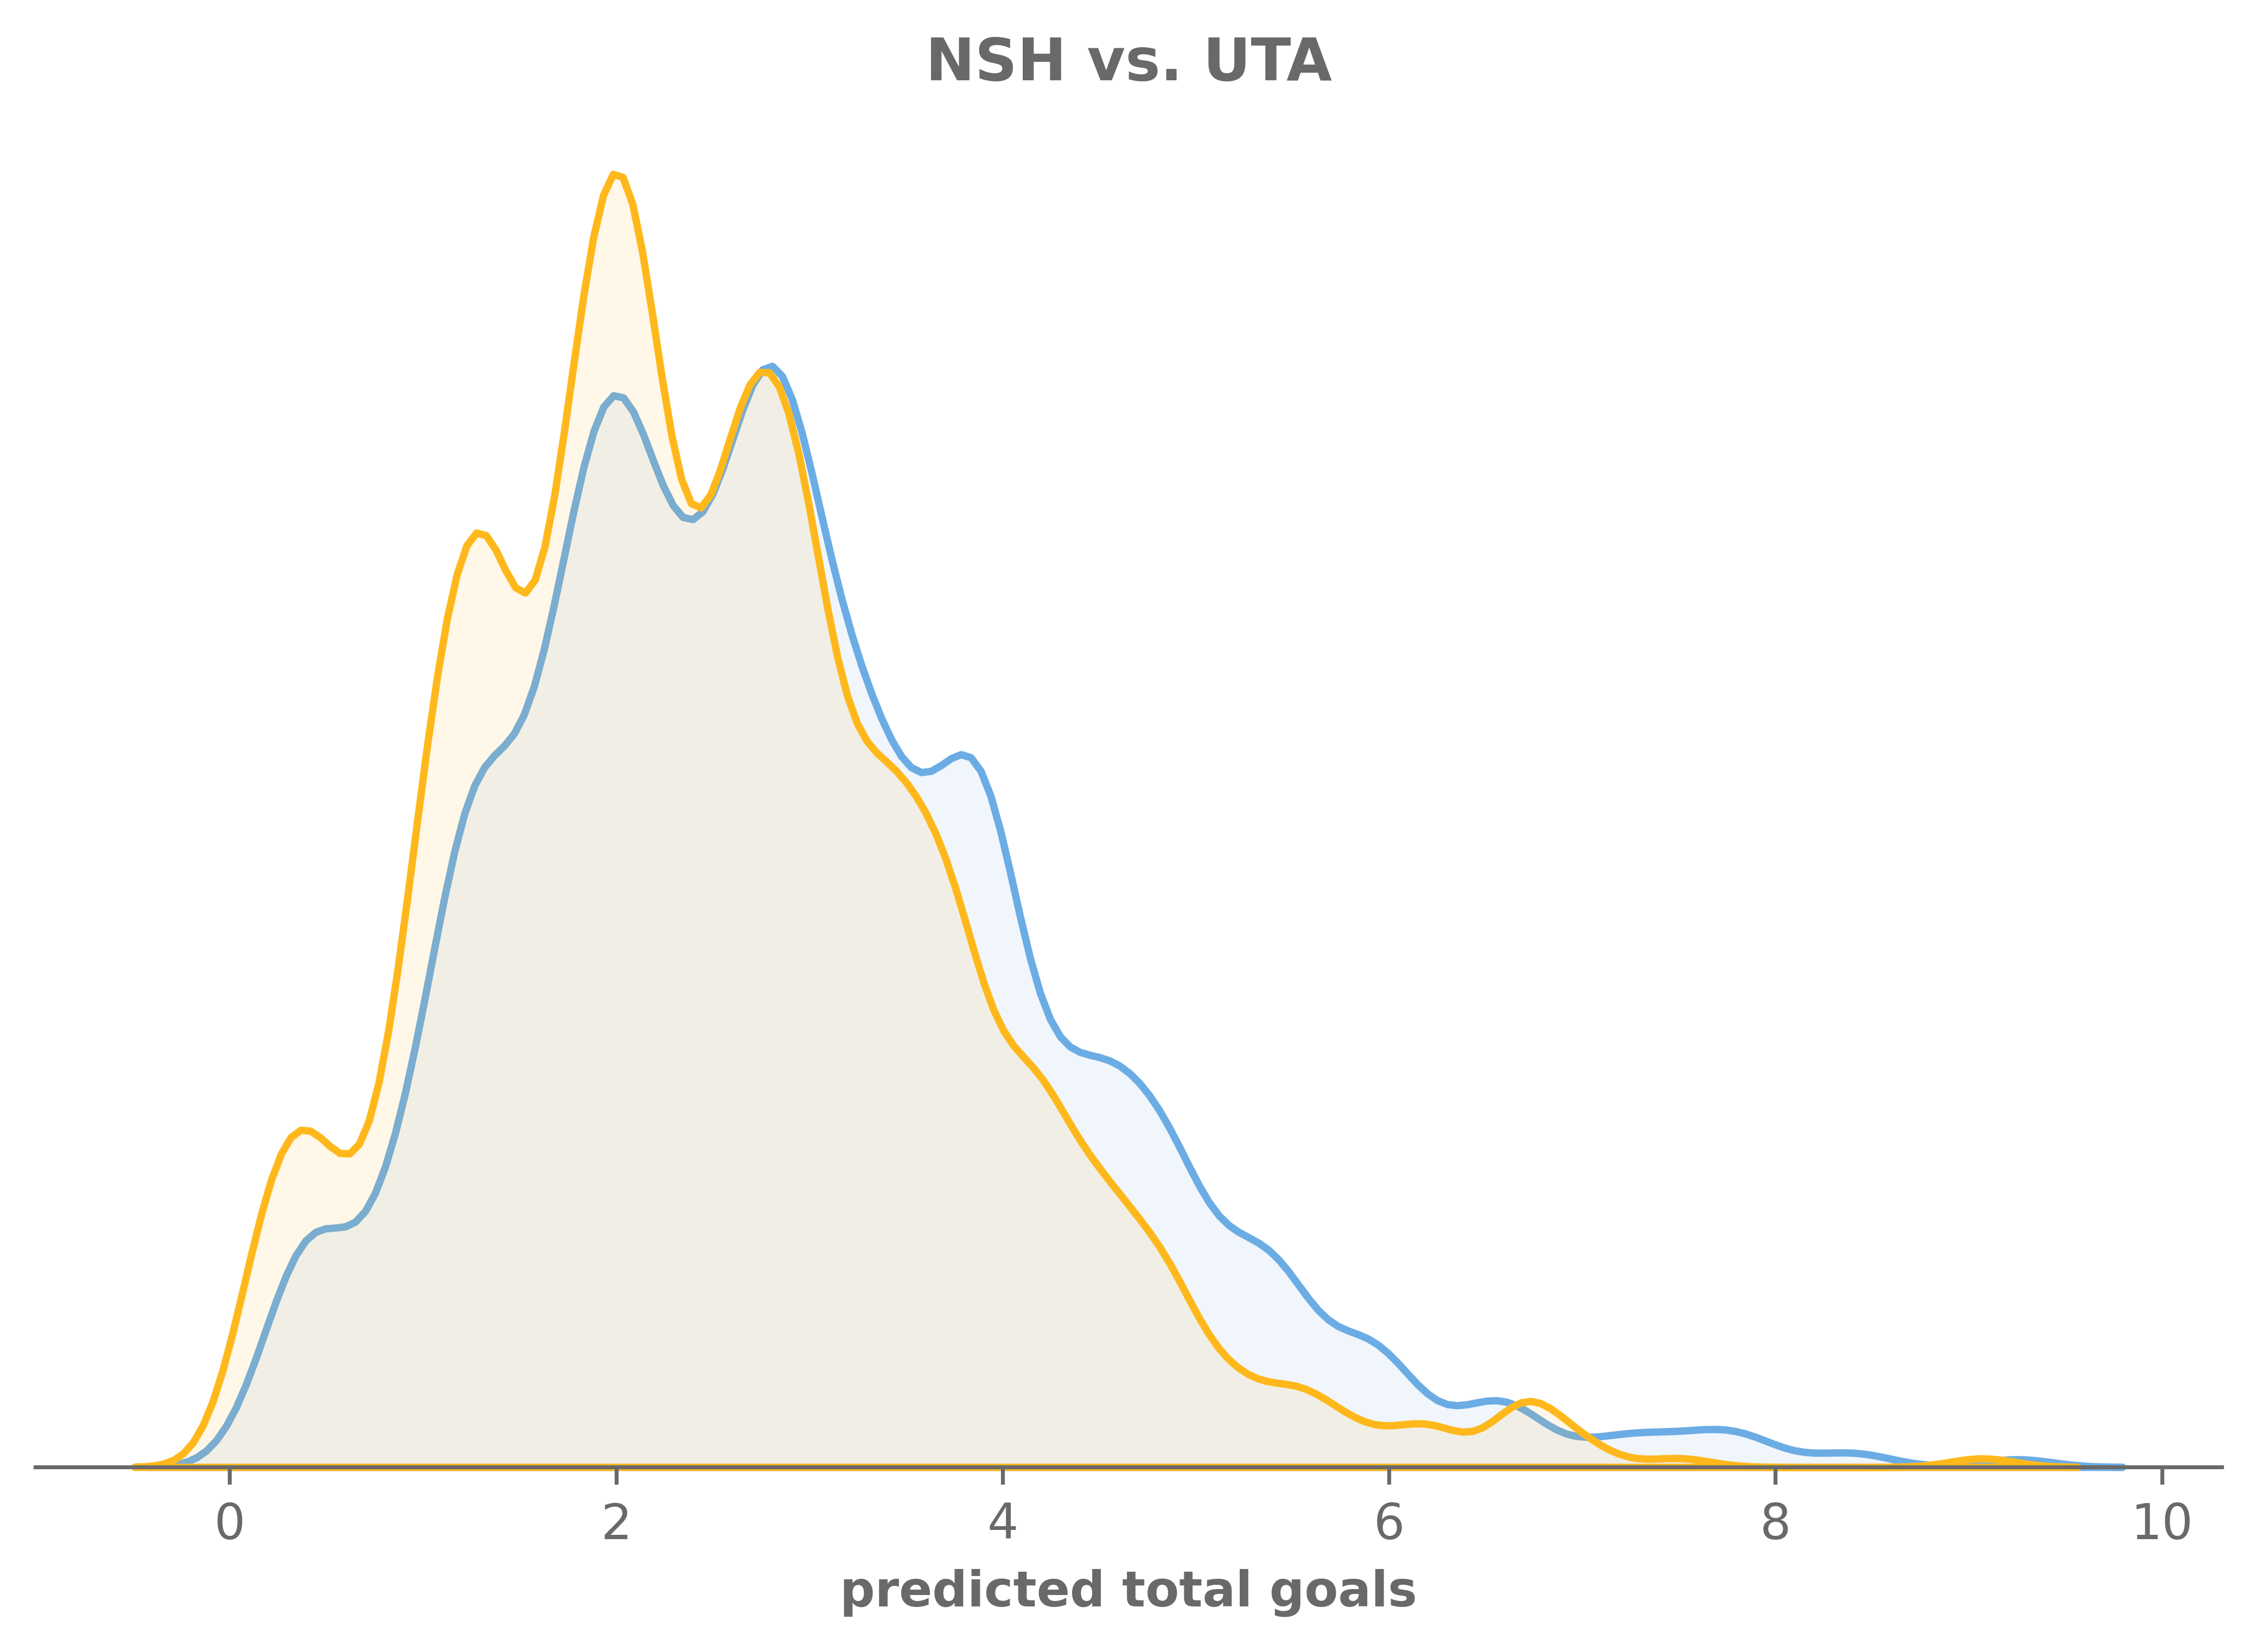

In [ ]:
dpi = 650
figsize = (8, 5)
nrows = 1  # len(assessed_predictions["home_team"].to_list())
ncols = 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi, sharex=True, sharey=True)

for idx, game in enumerate(
    assessed_predictions.filter((pl.col("away_team") == "NSH") | (pl.col("home_team") == "NSH"))
    .sort("predicted_away_total_goals_mean")
    .to_dicts()
):
    # ax = axs[idx]

    plot_predictions = predictions.filter(pl.col("game_id") == game["game_id"])

    venues = ["away", "home"]

    for venue in venues:
        sns.kdeplot(
            data=plot_predictions,
            x=plot_predictions[f"predicted_{venue}_total_goals"],
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=0.1,
            linewidth=1.5,
            hue=plot_predictions[f"{venue}_team"],
            palette=color_dict,
            legend=False,
            ax=ax,
        )

    sns.despine(left=True)

    ax.set(yticks=[], ylabel="", xlabel="predicted total goals")

    if idx != (nrows - 1):
        ax.set(xticks=[])

    # else:
    #     ax.set(xlabel="predicted total goals")

    ax.set_title(f"{game['home_team']} vs. {game['away_team']}")

fig.savefig(f"./charts/{latest_date}_NSH.png", dpi=650, bbox_inches="tight", facecolor="white")

### Plotting today's games
Plotting the predicted goals for all of today's games

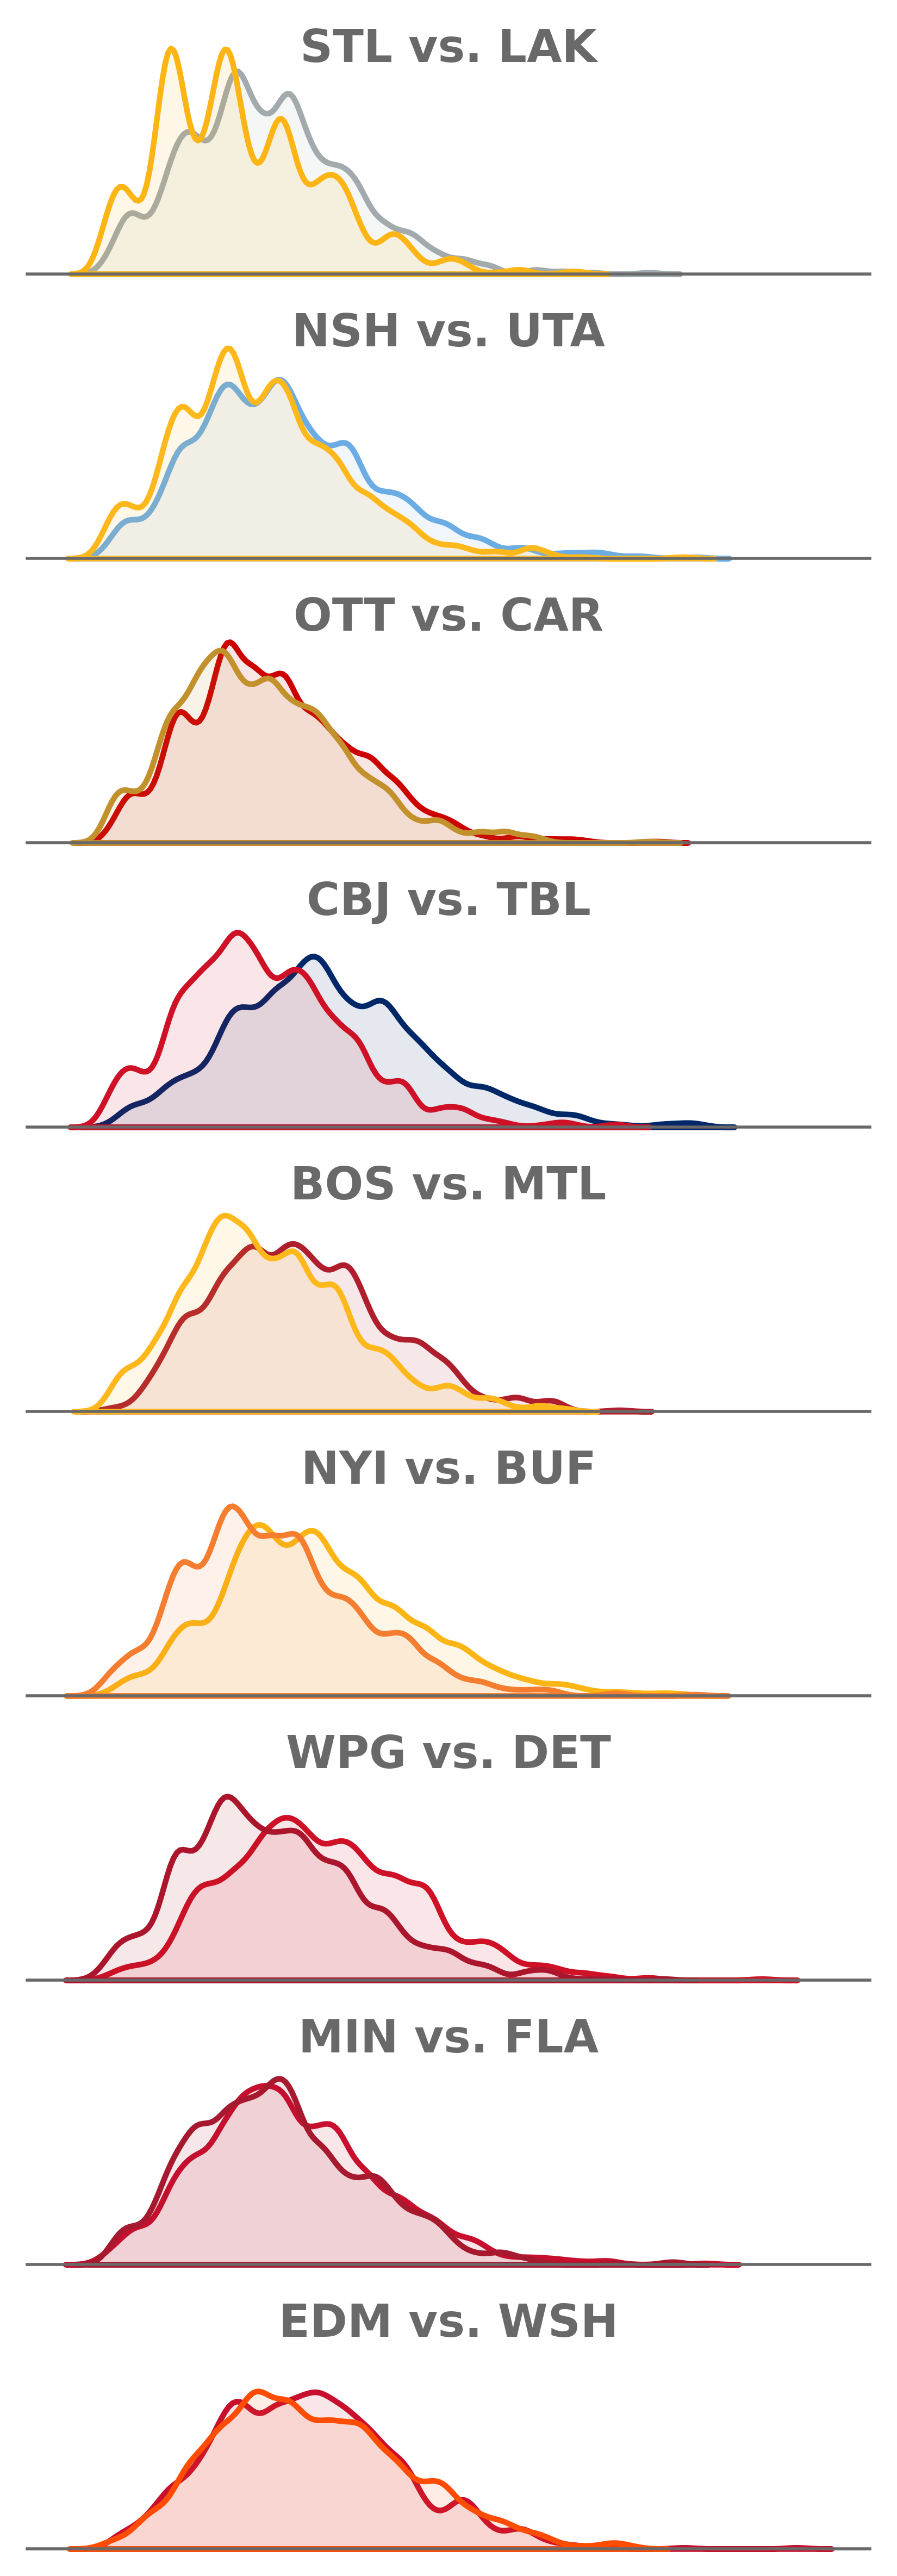

In [ ]:
dpi = 500
figsize = (4, 12)
nrows = len(assessed_predictions["home_team"].to_list())
ncols = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi, sharex=True, sharey=True)

for idx, game in enumerate(assessed_predictions.sort("predicted_home_total_goals_mean").to_dicts()):
    ax = axs[idx]

    plot_predictions = predictions.filter(pl.col("game_id") == game["game_id"])

    venues = ["away", "home"]

    for venue in venues:
        sns.kdeplot(
            data=plot_predictions,
            x=plot_predictions[f"predicted_{venue}_total_goals"],
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=0.1,
            linewidth=1.5,
            hue=plot_predictions[f"{venue}_team"],
            palette=color_dict,
            legend=False,
            ax=ax,
        )

    sns.despine(left=True)

    ax.set(yticks=[], ylabel="")

    if idx != (nrows - 1):
        ax.set(xticks=[])

    # else:
    #     ax.set(xlabel="predicted total goals")

    ax.set_title(f"{game['home_team']} vs. {game['away_team']}", y=0.8)

fig.savefig(f"./charts/{latest_date}.png", dpi=650, bbox_inches="tight", facecolor="white")

## Assessing predictions
Seeing how the season long predictions have been playing

### Downloading the data from GitHub
Downloading the data from the `chickenstats` repository on GitHub

In [ ]:
csv_url = "https://raw.githubusercontent.com/chickenandstats/chickenstats-blog/refs/heads/main/nbs/blog/posts/tutorials/monte_carlo/results/predicted_winners.csv"

season_predictions = pl.read_csv(csv_url)

In [ ]:
season_predictions.head(10)

game_id,home_team,away_team,predicted_winner,actual_winner,prediction_correct,predicted_home_win,predicted_away_win,predicted_draw,predicted_home_win_percent,predicted_away_win_percent,predicted_draw_percent,predicted_home_5v5_goals_mean,predicted_home_powerplay_goals_mean,predicted_home_total_goals_mean,predicted_home_5v5_xgf_p60_mean,predicted_home_powerplay_xgf_p60_mean,predicted_home_5v5_toi_mean,predicted_home_powerplay_toi_mean,predicted_home_shorthanded_toi_mean,predicted_away_5v5_goals_mean,predicted_away_powerplay_goals_mean,predicted_away_total_goals_mean,predicted_away_5v5_xgf_p60_mean,predicted_away_powerplay_xgf_p60_mean,predicted_away_5v5_toi_mean,predicted_away_powerplay_toi_mean,predicted_away_shorthanded_toi_mean
i64,str,str,str,str,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025020695,"""WPG""","""LAK""","""LAK""","""WPG""",0,4060,5892,48,0.406,0.5892,0.0048,1.956666,0.641295,2.597961,2.5485,7.1324,46.105153,5.400488,4.396158,2.202071,0.824131,3.026202,2.8657,11.2256,46.105153,4.396158,5.400488
2025020530,"""DET""","""UTA""","""UTA""","""UTA""",1,4511,5435,54,0.4511,0.5435,0.0054,2.187779,0.527668,2.715447,2.7515,6.9293,47.688887,4.564279,3.723834,2.512217,0.435366,2.947583,3.1607,7.008,47.688887,3.723834,4.564279
2025020148,"""PIT""","""STL""","""STL""","""PIT""",0,2056,7903,41,0.2056,0.7903,0.0041,1.962572,1.252185,3.214757,2.782,9.6232,42.352182,7.806185,6.377632,3.922311,1.086998,5.00931,5.5547,10.2336,42.352182,6.377632,7.806185
2025020593,"""CAR""","""DET""","""DET""","""CAR""",0,4917,5037,46,0.4917,0.5037,0.0046,2.486878,0.699148,3.186026,3.1919,9.9487,46.735572,4.217244,4.457284,2.362811,0.840152,3.202963,3.0351,11.309,46.735572,4.457284,4.217244
2025020427,"""OTT""","""NYR""","""NYR""","""NYR""",1,3814,6144,42,0.3814,0.6144,0.0042,1.583031,0.48285,2.065881,1.9963,6.3484,47.649183,4.570142,3.926674,1.909994,0.669286,2.57928,2.4068,10.228,47.649183,3.926674,4.570142
2025020712,"""BOS""","""PIT""","""PIT""","""BOS""",0,3955,5997,48,0.3955,0.5997,0.0048,2.251294,0.423561,2.674854,2.82,5.8083,47.907743,4.377982,3.811276,2.579232,0.621881,3.201113,3.2312,9.8068,47.907743,3.811276,4.377982
2025020329,"""ANA""","""OTT""","""OTT""","""OTT""",1,3673,6274,53,0.3673,0.6274,0.0053,1.782043,0.533371,2.315414,2.3281,8.1117,45.880385,3.939515,5.5705,2.322641,0.583617,2.906258,3.0382,6.2758,45.880385,5.5705,3.939515
2025020478,"""UTA""","""FLA""","""UTA""","""FLA""",0,5255,4681,64,0.5255,0.4681,0.0064,2.160342,0.722947,2.883289,3.0104,7.2158,43.032919,5.999608,6.071273,1.920013,0.8197,2.739713,2.6752,8.1008,43.032919,6.071273,5.999608
2025020665,"""CGY""","""SEA""","""CGY""","""SEA""",0,6768,3177,55,0.6768,0.3177,0.0055,2.404052,0.712321,3.116374,3.0099,9.7929,47.894337,4.372837,3.531827,1.704213,0.540618,2.244831,2.1322,9.1522,47.894337,3.531827,4.372837


## Checking the results
Let's see how the simulation does

In [ ]:
season_predictions.select(
    pl.col("prediction_correct").sum().alias("correct_predictions"),
    pl.col("game_id").n_unique().alias("total games"),
    (pl.col("prediction_correct").sum() / pl.col("game_id").n_unique()).alias("correct_prediction_percent"),
)

# Kind of meh, TBH

correct_predictions,total games,correct_prediction_percent
i64,u32,f64
414,796,0.520101
